In [53]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's radically change the mixing matrix for the stochastic block model.

In [ ]:
## Create Graph ##

import numpy as np
from numpy.typing import NDArray
import networkx as nx
import matplotlib.pyplot as plt
from Girvan_Newman_stochastic_block_network_v2 import AssortativeMixing
from drawing_utilities import show_partitions
from drawing_utilities import show_graph
from drawing_utilities import show_dendrogram
from partitioning_utilities import modularity_spectral_split
from drawing_utilities import show_kCores


M: NDArray[np.float32] = np.array([[0.01, 0.01, 0.1, 0.1, 0.1],
                [0.01, 0.01, 0.1, 0.1, 0.1],
                [0.02, 0.01, 0.4, 0.4, 0.4],
                [0.01, 0.04, 0.4, 0.4, 0.4],
                [0.03, 0.02, 0.4, 0.4, 0.4]])
modular_network = AssortativeMixing(M=M, poisson_lambda=[2,2,3,4,5], num_edges=400)
G: nx.Graph = modular_network.G


In [55]:
def largest_component(graph):
    # Find all connected components
    components = nx.connected_components(graph)
    
    # Get the largest component
    largest = max(components, key=len)
    
    return graph.subgraph(largest)

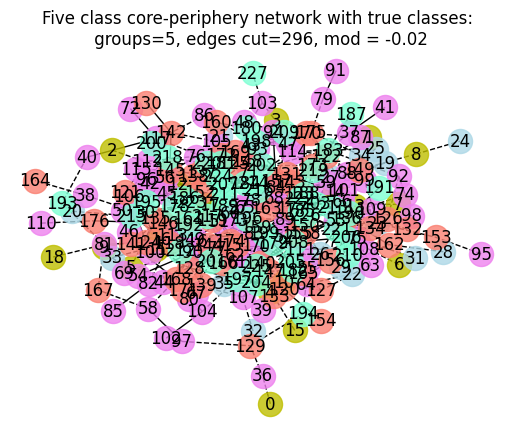

In [56]:
G = largest_component(G)

group_ids: list[int] = list({G.nodes[node]["node_class"] for node in G.nodes()})
partition: list[set[int]] = []
for group_id in group_ids:
    group: set[int] = {node for node in G.nodes() if G.nodes[node]["node_class"] == group_id}
    partition.append(set(group))
show_partitions(G, partition, title="Five class core-periphery network with true classes:\n")


The graph doesn't look like it has any communities. Let's look at the dendrogram to learn more.

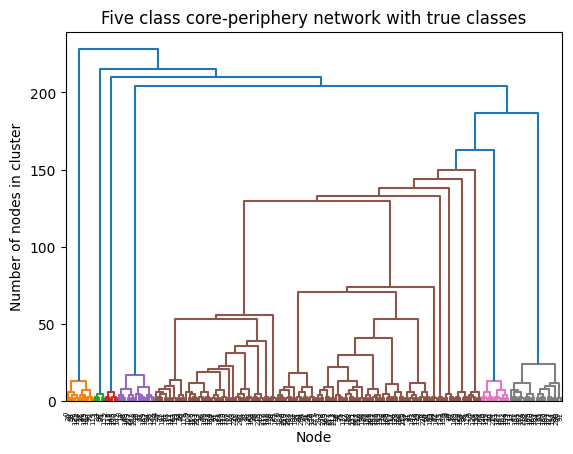

In [57]:
show_dendrogram(G, title="Five class core-periphery network with true classes")

It looks like there is a set of nodes that form something like a community, and then a bunch of little tiny communities or lone nodes. Let's see what the Louvain algorithm comes up with.

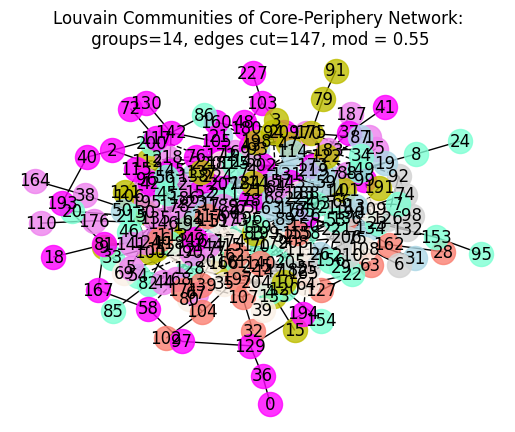

In [58]:
partitions = nx.community.louvain_communities(G, seed=42)
show_partitions(G, partition=partitions, title="Louvain Communities of Core-Periphery Network:\n")

How about spectral clustering.

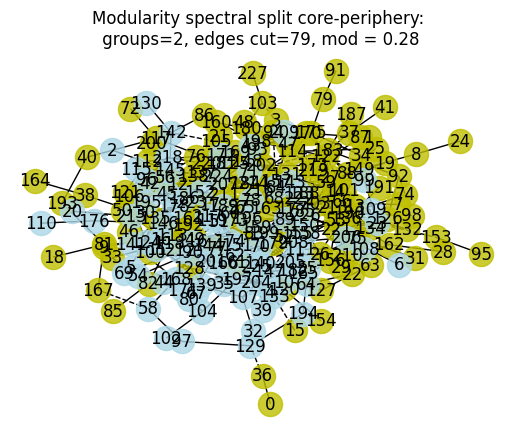

In [59]:
partitions = modularity_spectral_split(G)
show_partitions(G, partitions, title="Modularity spectral split core-periphery:\n")

Nope, it doesn't appear that there are any good communities. 

---

But there is structure in the network, just not community structure as defined by modularity.  The network is known as _core-periphery network_. The defining characteristic of core-periphery networks is that they have a lot of nodes that lump together in a common component and some other nodes that attach to the nodes in the common component. 

Let's call a mysterious method from graph_handler. This method groups nodes into classes, displays all nodes of the same class with the same color, and displays each class on a sequence of nested circles.


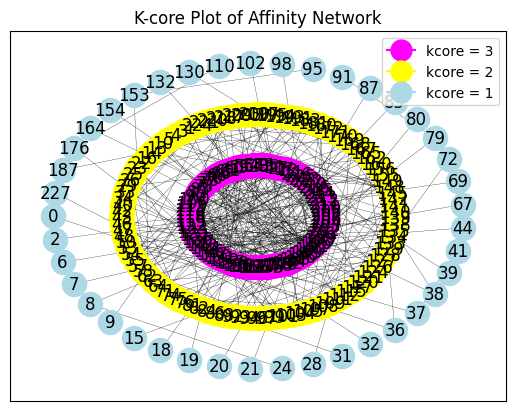

In [60]:
show_kCores(G, title="K-core Plot of Affinity Network")



Let's start building the mathematical formalism and intuition for determining when a network has a core-periphery structure. We'll begin by creating the network from Figure 2 in

```
    Malliaros, F. D., Giatsidis, C., Papadopoulos, A. N., & Vazirgiannis, M. (2020). The core decomposition of networks: Theory, algorithms and applications. The VLDB Journal, 29, 61-92.
```

In [61]:
import networkx as nx
G = nx.Graph()
colormap = []
# Three core
new_nodes = [0,1,2,3,4]
G.add_nodes_from(new_nodes)
[colormap.append('m') for x in new_nodes]
G.add_edges_from([[0,1],[0,2],[0,3],[0,4],
                  [1,2],[2,3],[3,4],[4,1]])
# Two core
new_nodes = [5,6,7,8,9,10,11,12,13,14,15,16]
G.add_nodes_from(new_nodes)
[colormap.append('y') for x in new_nodes]
G.add_edges_from([[5,6],[6,7],[7,8],[8,5]])
G.add_edges_from([[1,6],[4,7]])
G.add_edges_from([[1,9],[2,9]])
G.add_edges_from([[10,11],[11,12],[12,13],[13,10]])
G.add_edges_from([[2,10],[3,12]])
G.add_edges_from([[14,15],[15,16],[16,14]])
G.add_edges_from([[3,14]])
# 1-core
new_nodes = [17,18,19,20,21,22,23,24,25,26,27,28]
G.add_nodes_from(new_nodes)
[colormap.append('lightblue') for x in new_nodes]
G.add_edges_from([[17,18],[5,17]])
G.add_edges_from([[19,20],[20,21],[2,19]])
G.add_edges_from([[22,23],[22,24],[11,22]])
G.add_edges_from([[15,25],[16,26]])
G.add_edges_from([[27,28],[8,27]])


The definition of a k-core (adapted from the reference in the previous cell and from section 7.2.2 of Newman's Networks book) is:

$G_k$ is a $k$-core of graph $G$ if it is a maximal subgraph of $G$ in which all nodes have degree of at least $k$.

The phrase _maximal subgraph_ means there isn't another subgraph, denoted $H$, of $G$ such that
 - all nodes in $H$ also have degree of at least $k$, and
 - $G_k$ is a proper subgraph of $H$.
Intuitively, maximal subgraph means there isn't a bigger subgraph that has the same properties.

Let's draw the graph from the reference in the previous cell.

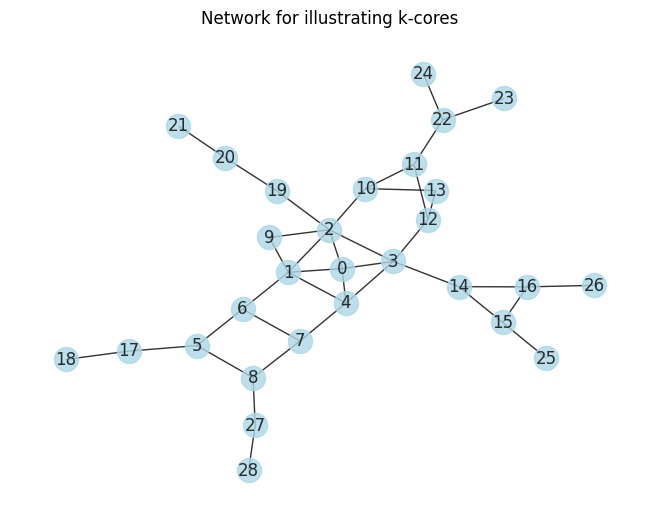

In [62]:
show_graph(G, title="Network for illustrating k-cores")


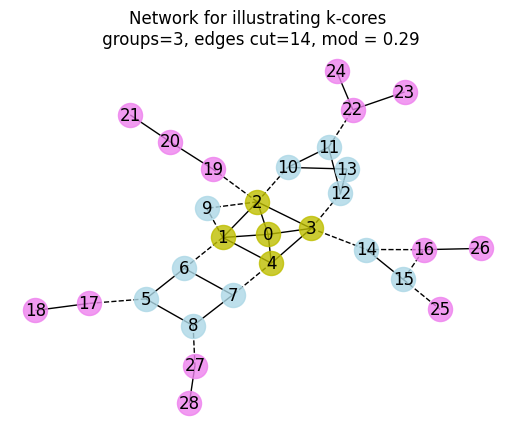

In [63]:
partition: tuple[set[int]] = ({0,1,2,3,4},
                              {5,6,7,8,9,10,11,12,13,14,15},
                              {16,17,18,19,20,21,22,23,24,25,26,27,28})
show_partitions(G, partition, title="Network for illustrating k-cores\n")

Consider the yellow nodes in the center of the network. Notice that each magenta node has three yellow neighbors and a handful of other neighbors. Let's remove all the light blue and magenta nodes. 

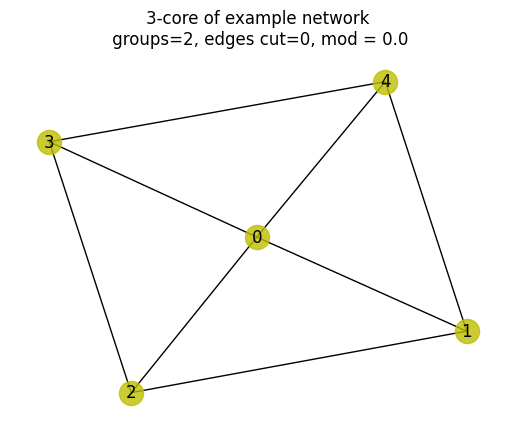

In [64]:
H=G.subgraph([0,1,2,3,4]).copy()
show_partitions(H,partition=(set(H.nodes()), set()), title="3-core of example network\n")


Notice that all the nodes in the graph have a degree of at least three. The subgraph formed by pruning all but the yellow nodes is the 3-core, $G_3$. 

Notice that there is no 4-core graph, $G_4$. If I try to construct one containing only the middle node then I have to delete nodes on the periphery, but each time I delecte a peripheral node the degree of the middle node goes down. Thegraph $G_3$ is called the _maximal $k$-core subgraph_ of $G$ since there is no 4-core subgraph.

---

There is a simple algorithm for finding all $k$-core subgraphs. Quoting from Newman, section 7.2.2,

"A simple way to find [$k$-cores] is to start with a given network and remove from it any nodes that have degree less than $k$, along with theire attached edges, since clearly such nodes cannot under any circumstances be members of a $k$-core. In doing so, one will normally reduce the degrees of some other nodes in the network -- those that were connected to the nodes that were just removed. So we then go through the network again to see if there area ny additional nodes that now have degree less than $k$ and remove those too. And so we proceed, repeatedly pruning the network to remove nodes with degree less thatn $k$ until no such nodes remain."

Let's implement this algorithm.

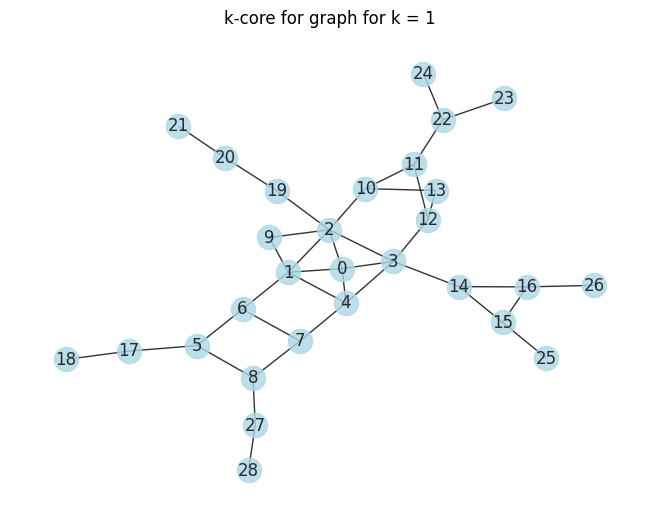

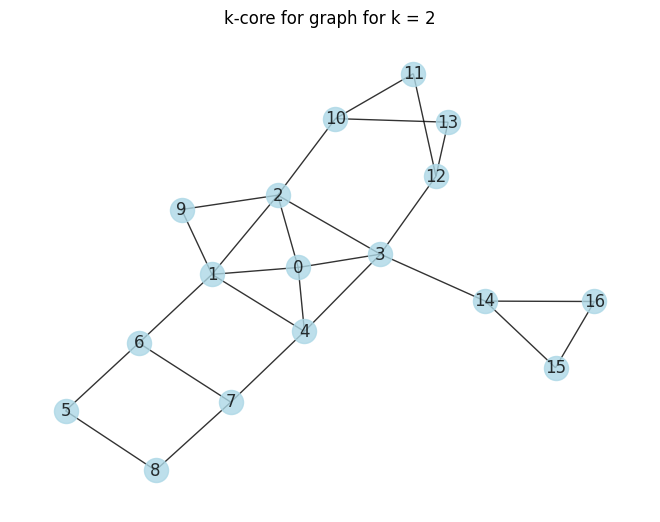

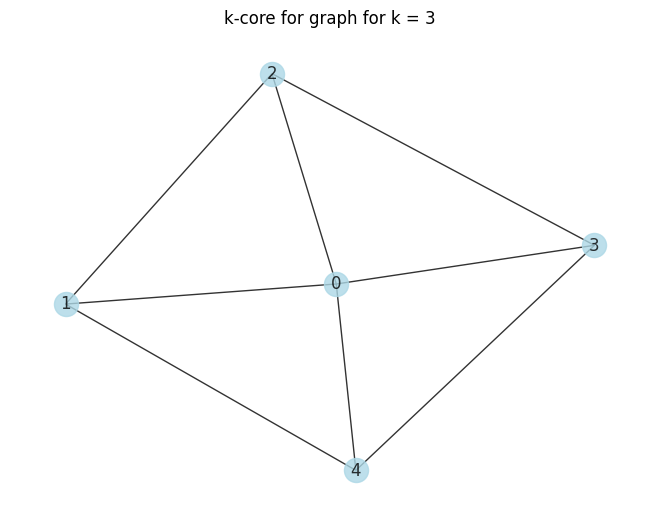

In [67]:
import networkx as nx
import matplotlib.pyplot as plt
pos = nx.nx_pydot.pydot_layout(G, prog = "neato")
kcores = dict()
kcores[1] = G.copy()  # the $1$ core is the original graph
for k in [2,3]:
    kcores[k] = kcores[k-1].copy()
    graph_changing = True
    while(graph_changing):
        graph_changing = False
        for node in list(kcores[k].nodes):
            if kcores[k].degree(node) < k:
                kcores[k].remove_node(node)
                graph_changing = True
for k in [1,2,3]:
    plt.figure()
    show_graph(kcores[k], pos, title=f"k-core for graph for k = {k}")
    #nx.draw(kcores[k], pos)
    #plt.title(f"kcore graph for k = {k}")



Although it's hard to see because I didn't use colors, the 1-core is the original graph, the 2-core is the subgraph created when the yellow nodes are removed from the 1-graph graph, and the 3-core is the subgraph created when the light blue nodes are removed from the 2-core graph.

There are more efficient algorithms. See the reference above for a review.

---

Networkx has a layout that puts nodes into nested shells. Thanks to [Corralien's response on stackoverflow](https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx) for a template for using the shell layout to visualize the k-cores. We'll put the nodes in the k-core with the largest value of $k$ in the middle, and then put nodes in the $k-1$ core in the next shell, and so on.

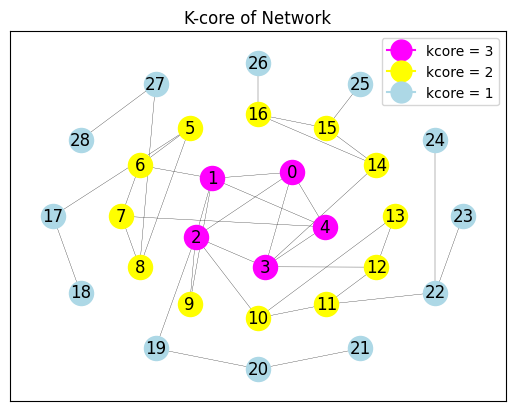

In [68]:
show_kCores(G)

When we plot the network we constructed at the start of the tutorial, we see the following:

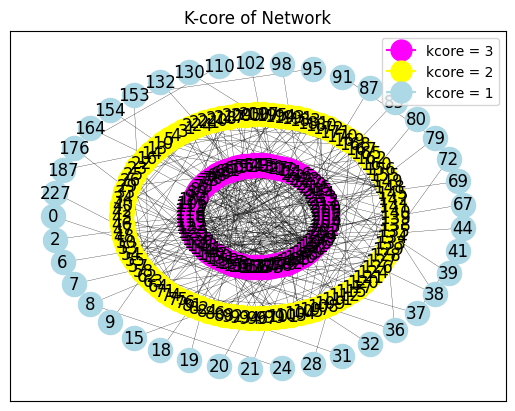

In [69]:
show_kCores(modular_network.G)

We can now understand the structure of the network. It has a very large core of nodes in the $k$-core with the largest value of $k$ and a handful of nodes in lesser $k$-cores. The very large number of nodes in the maximal $k$-core subgraph tells us that this graph has a core-periphery structure.

---

In class practice. Create a connected graph with
 - five nodes in the 4-core
 - eight nodes in the 3-core
 - ten nodes in the 2-core
 - eleven node in the 1-core

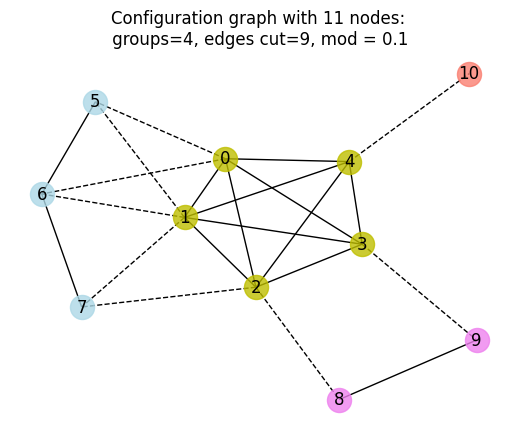

In [70]:
G = nx.Graph()
partition: list[set[int]] = []

# Four core
new_nodes = [0,1,2,3,4]
G.add_nodes_from(new_nodes)
partition.append(set(new_nodes))
G.add_edges_from([[0,1],[0,2],[0,3],[0,4],
                  [1,2],[1,3],[1,4],
                  [2,3],[2,4],
                  [3,4]])
# Three core
new_nodes = [5,6,7]
G.add_nodes_from(new_nodes)
partition.append(set(new_nodes))
G.add_edges_from([[5,0],[5,1],[5,6],
                  [6,0],[6,1],
                  [7,1],[7,2],[7,6]])

# Two core
new_nodes = [8,9]
G.add_nodes_from(new_nodes)
partition.append(set(new_nodes))
G.add_edges_from([[8,2],[8,9],[9,3]])

# One core
new_nodes = [10]
G.add_nodes_from(new_nodes)
partition.append(set(new_nodes))
G.add_edges_from([[10,4]])


show_partitions(G, partition, title="Configuration graph with 11 nodes:\n")


---

Let's look at the core periphery structure of the karate graph

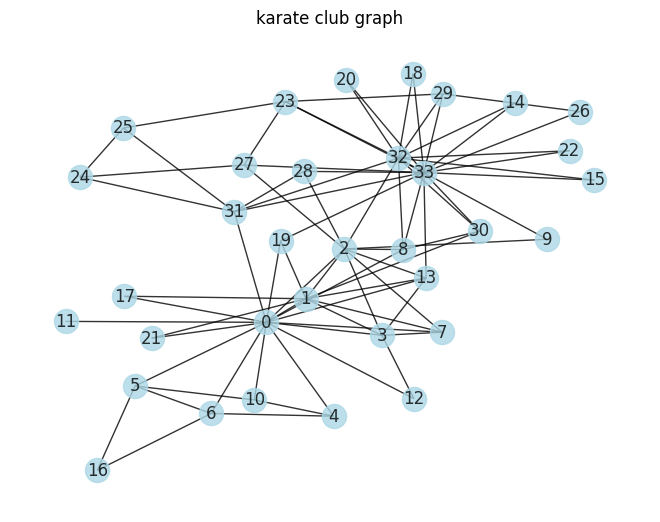

In [71]:
G = nx.karate_club_graph()
show_graph(G, title="karate club graph")


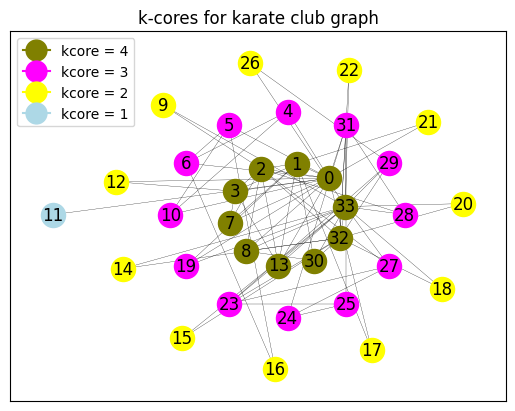

In [72]:
show_kCores(G, title="k-cores for karate club graph")

... and the les Miserables graph

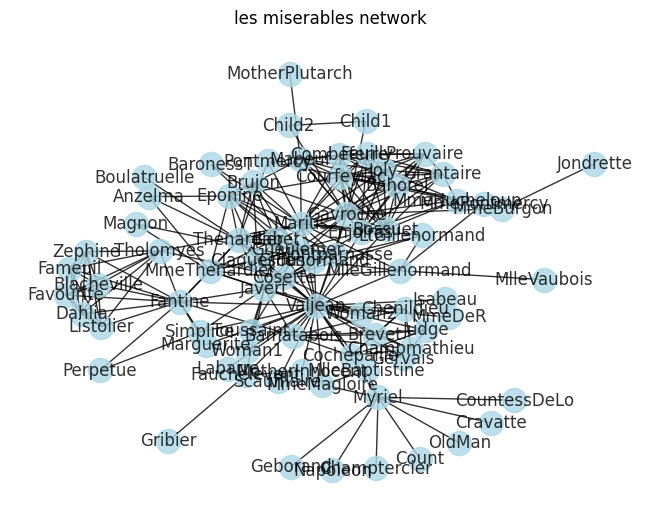

In [75]:
G = nx.les_miserables_graph()
show_graph(G, title="les miserables network")

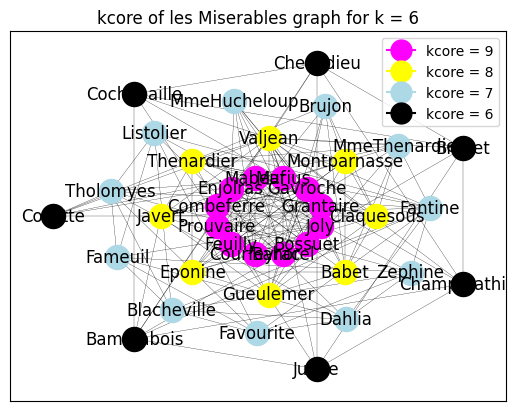

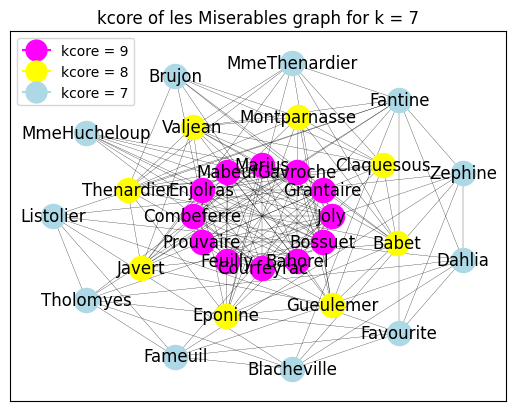

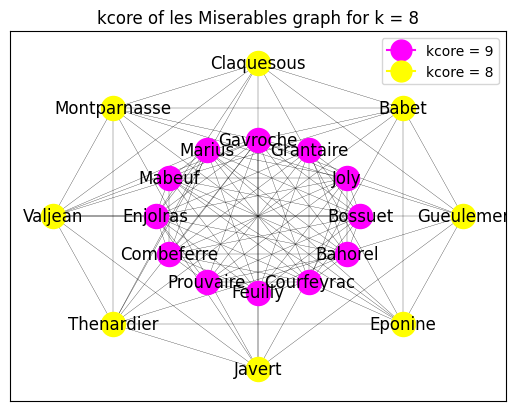

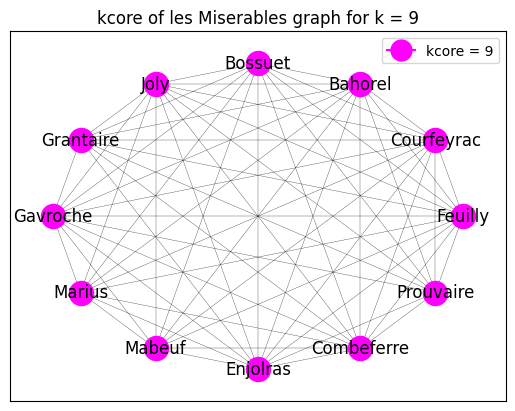

In [79]:
kcores = dict()
kcores[1] = G.copy()  # the $1$ core is the original graph
for k in [2,3,4,5,6,7,8,9]:
    kcores[k] = kcores[k-1].copy()
    graph_changing = True
    while(graph_changing):
        graph_changing = False
        for node in list(kcores[k].nodes):
            if kcores[k].degree(node) < k:
                kcores[k].remove_node(node)
                graph_changing = True
for k in [6,7,8,9]:
    plt.figure()
    show_kCores(kcores[k],title=f"kcore of les Miserables graph for k = {k}")


Before leaving this tutorial, it is helpful to note that core-periphery structures are very relevant to complex contagions; see Newman section 16.1.9 and section 16.3.5. Specifically, let's adopt the following model of complex contagion: an agent requires only two of its neighbors to adopt a technology or belief before it will. Now suppose that a few agents in the maximal $k$-core are early adopters. As long as the early adopters share a common neighbor, we'd expect a cascade to go through almost the entire maximal $k$-core. Thus, the core of the network will adopt the technology, though nodes on the periphery are not likely to.

This leads to an interesting observation. Node importance can include things beyond what we captured with eigenvector centrality, Katz centrality, and Pagerank. In the case of a complex contagion, a node might not be important for spreading a contagion unless it not only is highly connected but also has highly connected neighbors.